# GR5293 - Proj1 - Group9
## Classification on the late payment of credit cards
#### Machine learning pipeline with random forest
* Feature Engineering
* Train validation test split
* K-fold cross validation
* Rank the feature importance to interpret the result and give the orientation of further dimension reduction to enhance the depoliability of our model, state its business value
* Focus on AUC and recall!
* Plot the ranked feature importance barplot(horizontal), the AUC curve with different predictor sets
* Plot the training / testing error curve
* Plot the cv scores in feature selection (/w number of components)

### Setup

In [68]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE
import matplotlib
from matplotlib import pyplot as plt
import time
import os
import re
import gc
gc.enable()
print(os.getcwd())
mydir = os.getcwd() + "/"
%xmode plain
%matplotlib inline

/Users/kangshuoli/Documents/VScode_workspace/GR5293/EODS-Project1-Group9/doc
Exception reporting mode: Plain


### Read in and post-process the data
#### Split the features and label
#### Post-process the data
##### Make corrections on data type
* Extract columns with "FLAG", "TYPE" in their names as categorical data
* Some columns with all integers but have "CNT", "DAYS" in their names would not be converted
* Unique value <= 10 can be interpreted as categorical
  
#### Delete some special columns by screening
* Drop predictors with AVG MODE MEDI, only keep medians
  
#### Stadardize
* Only standardize columns with non-categorical data

In [42]:
fraud_df = pd.read_csv(
    '../data/fraud_cleaned_ver3.csv', 
    header = 0
)
fraud_df = fraud_df.iloc[:,1:]
print(f'fraud_df shape: {fraud_df.shape}')

feature_df = fraud_df.iloc[:,1:]
response_df = fraud_df.loc[:,"TARGET"].astype(int)

categorical_col_list = []
for name in feature_df.columns:
    if len(feature_df[name].unique()) <= 10:
        categorical_col_list.append(name)
        feature_df[name] = feature_df[name].astype(int)

pattern_avg_mode = re.compile('(.*_AVG$|.*_MODE$)')
dup_col_list = []
for name in feature_df.columns:
    if re.search(pattern_avg_mode, name):
        dup_col_list.append(name)

feature_df.drop(
    dup_col_list,
    inplace = True, 
    axis = 1
)

from sklearn.preprocessing import MinMaxScaler
# instantiate the scalar
minmax_scalar = MinMaxScaler(
    feature_range = (0, 1)
)
# split the feature_df into categorical and non-categorical subdf
feature_df_non_categorical = feature_df[[name for name in feature_df.columns if name not in categorical_col_list]]
feature_df_categorical = feature_df[[name for name in feature_df.columns if name in categorical_col_list]]

# only transform non_categorical df
feature_df_non_categorical_minmax = minmax_scalar.fit_transform(X = feature_df_non_categorical) # return np.ndarray
# convert it into a dataframe
feature_df_std_categorical_minmax = pd.DataFrame(
    data = feature_df_non_categorical_minmax, 
    columns = feature_df_non_categorical.columns
)
# concatenate categorical df and non-categorical df
feature_df_minmax = pd.concat([feature_df_std_categorical_minmax, feature_df_categorical], axis = 1)
# dtype conversion
for name in list(feature_df_minmax.columns):
    if name in categorical_col_list:
        feature_df_minmax[name] = feature_df_minmax[name].astype(int)


fraud_df shape: (71974, 154)


/var/folders/tz/1kfts8hs47xb2vd2_6cggx300000gn/T/ipykernel_66771/2336795513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df[name] = feature_df[name].astype(int)
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Define train test split function

In [43]:
def train_test_split_with_shuffle(feature_df_, response_df_ = response_df, test_size_ = 0.25):
    '''
    Implement train test split function and shuffle all the data
    Default using test_ratio = 0.25 and standardized dataframe
    Return global variables
    '''
    globals()['feature_train'], globals()['feature_test'], globals()['response_train'], globals()['response_test'] = train_test_split(
        feature_df_, 
        response_df_, 
        test_size = test_size_, 
        shuffle = True, 
        random_state = 42, 
        stratify = response_df_
    )
    globals()['response_train'] = pd.DataFrame(globals()['response_train'])
    globals()['response_test'] = pd.DataFrame(globals()['response_test'])
    list_p1 = ["feature", "response"]
    list_p2 = ["train", "test"]
    for p1 in list_p1:
        for p2 in list_p2:
            temp_var = p1 + '_' + p2
            print(f'The Size of {temp_var} is: {globals()[temp_var].shape}')

    # reshape the index
    # make them start from 0 and end at their shape[0] - 1
    for p1 in list_p1:
        for p2 in list_p2:
            temp_var = p1 + '_' + p2
            globals()[temp_var].index = np.arange(globals()[temp_var].shape[0], dtype = int)
    pass

#### Feature Engineering
* Feature selection by RFECV / SelectFromModel / PCA 
* Extreme imbalanced data -> resampling
* Only 6% of data is fraudulent this would cause the classifier onlt predict no fraudulent and get the result of 90%+ accuracy

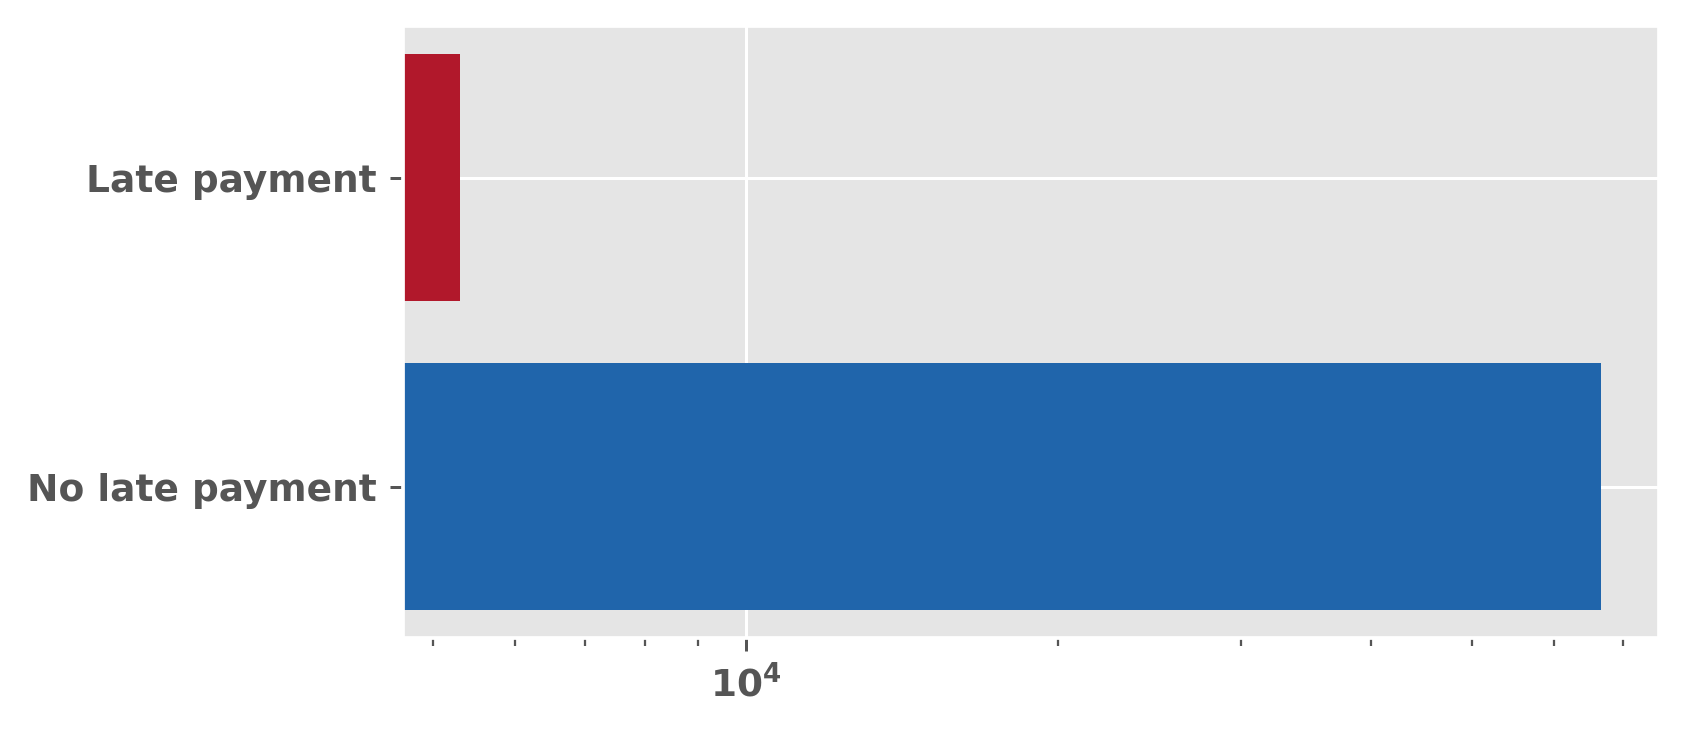

In [44]:
from matplotlib import cm
plt.style.use('ggplot')
plt.rcParams["font.weight"] = "bold"
my_colormap = cm.get_cmap(name = 'RdBu')
color_value = np.linspace(start = 0.9, stop = 0.1, num = 2)
fig, ax = plt.subplots(1, 1, figsize = (6,3), dpi = 270)
for i in np.arange(2):
    ax.barh(
        y = i, 
        width = response_df[response_df == i].shape[0], 
        label = i, 
        color = my_colormap(color_value[i])
    )
ax.set_yticks(np.arange(2), ["No late payment", "Late payment"])
ax.set_xscale('log')
# ax.set_xlabel("Count")
plt.show()

#### Resampling after train test split
* Random Under-Sampling / Random Over-Sampling / Random under-sampling with imblearn / Random over-sampling with imblearn / Under-sampling: Tomek links / Synthetic Minority Oversampling Technique (SMOTE) / NearMiss / 

Use undersampling here since the amount of data is large. (Low F1 score)
>Tomek links can extract the data from majority class "0" that are close to opposite classes. 
Try Synthetic Minority Oversampling Technique (SMOTE)

In [45]:
def resampling(type_, feature_train_, response_train_):
    if type_ == "RandomUnderSampler":
        sampler = RandomUnderSampler(
            sampling_strategy = "auto", 
            random_state = 42
        )
    elif type_ == "RandomOverSampler":
        sampler = RandomOverSampler(
            sampling_strategy = "auto", 
            random_state = 42
        )
    elif type_ == "SMOTE":
        sampler = SMOTE(
            sampling_strategy = "auto", 
            random_state = 42, 
            n_jobs = -1, 
            k_neighbors = 5
        )
    elif type_ == None:
         return feature_train_, response_train_
    feature_res, response_res = sampler.fit_resample(X = feature_train_, y = response_train_)             
    return feature_res, response_res

#### Define feature selection function

In [46]:
def feature_selection(feature_res_, response_res_, feature_test_, scoring_):
    from sklearn.ensemble import RandomForestClassifier
    seq = ["sfm", "rfe", "pca"]
    random_state_ = 42
    sfm_clf = SelectFromModel(
        estimator = RandomForestClassifier(
            # max_depth = 10, 
            # n_estimators = 600, 
            class_weight = "balanced"
        ), 
        threshold = None, 
        importance_getter = "auto", 
        norm_order = 1
    )
    rfe_clf = RFECV(
        estimator = RandomForestClassifier(), 
        min_features_to_select = 15, 
        cv = 10, 
        scoring = scoring_, 
        verbose = 0, 
        n_jobs = -1, 
        importance_getter = 'auto'
    )
    variance_explained = 0.90
    pca_clf = PCA(
        n_components = variance_explained, 
        svd_solver = "auto", 
        random_state = random_state_
    )   
    for type in seq:
        locals()[type + '_clf'].fit(X = feature_res_, y = response_res_)
        if type == 'sfm':
            feature_selected_sfm_clf = [name for i, name in enumerate(feature_res_.columns) if sfm_clf.get_support()[i] == True]
            feature_train_sfm_clf = pd.DataFrame(data = sfm_clf.transform(feature_res_), columns = feature_selected_sfm_clf)
            feature_test_sfm_clf = pd.DataFrame(data = sfm_clf.transform(feature_test_), columns = feature_selected_sfm_clf)
        elif type == "rfe":
            feature_selected_rfe_clf = [name for i, name in enumerate(feature_res_.columns) if rfe_clf.get_support()[i] == True]
            feature_train_rfe_clf = pd.DataFrame(data = rfe_clf.transform(feature_res_), columns = feature_selected_rfe_clf)
            feature_test_rfe_clf = pd.DataFrame(data = rfe_clf.transform(feature_test_), columns = feature_selected_rfe_clf)
            # get ranking in rfe
            feature_rfe_rank = rfe_clf.ranking_
        elif type == 'pca':
            feature_train_pca_clf = pd.DataFrame(pca_clf.transform(feature_res_), columns = np.arange(pca_clf.n_components_, dtype = int))
            feature_test_pca_clf = pd.DataFrame(pca_clf.transform(feature_test_), columns = np.arange(pca_clf.n_components_, dtype = int))
    for type in seq:
        print(type + '----------------------------------------------------------------')
        if type == 'sfm':
            print(f'Feature Importance Threshold: {sfm_clf.threshold_:0.4f} \nSelected Features: \n{feature_df_sfm_clf.columns}\n Number of Selected Features: {len(feature_selected_sfm_clf)}')
        elif type == 'rfe':
            print(f'Selected Features: \n{feature_df_rfe_clf.columns}\n Number of Selected Features: {len(feature_selected_rfe_clf)}')
        elif type == 'pca':
            print(f'Variance explained: {np.sum(pca_clf.explained_variance_ratio_):0.4f} \nNumber of Components: {pca_clf.n_components_}')

    return sfm_clf, rfe_clf, pca_clf, feature_train_sfm_clf, feature_test_sfm_clf, feature_train_rfe_clf, \
        feature_test_rfe_clf, feature_train_pca_clf, feature_test_pca_clf, feature_rfe_rank

#### Define learning function

In [47]:
def learning(searchtype_, param_grid_, scoring_, feature_selected_, response_res_):
    from sklearn.ensemble import RandomForestClassifier
    if searchtype_ == "Grid":
        gridsearch_clf = GridSearchCV(
            estimator = RandomForestClassifier(), 
            param_grid = param_grid_, 
            scoring = scoring_,
            cv = 10, 
            verbose = 2, 
            n_jobs = -1
        )
        gridsearch_clf.fit(X = feature_selected_, y = np.array(response_res_).ravel())
        best_rf_clf = gridsearch_clf.best_estimator_
        best_score_clf = gridsearch_clf.best_score_
        best_params_clf = gridsearch_clf.best_params_
        training_score_list = gridsearch_clf.cv_results_
    elif searchtype_ == "Random":
        randomsearch_clf = RandomizedSearchCV(
            estimator = RandomForestClassifier(), 
            param_distributions = param_grid_, 
            n_iter = 10, 
            scoring = scoring_,
            cv = 10, 
            verbose = 2, 
            n_jobs = -1,
            return_train_score = True
        )
        randomsearch_clf.fit(X = feature_selected_, y = np.array(response_res_).ravel())
        best_rf_clf = randomsearch_clf.best_estimator_
        best_score_clf = randomsearch_clf.best_score_
        best_params_clf = randomsearch_clf.best_params_
        training_score_list = randomsearch_clf.cv_results_
    
    print(f'Search Method: {searchtype_}\nScoring: {scoring_}\nThe best params: \n{best_params_clf}\nBest Score: {best_score_clf:0.4f}')
    return best_rf_clf, best_score_clf, best_params_clf, training_score_list


#### Define prediction function

In [48]:
def prediction(selector_, clf_, best_params_clf_, feature_test_, response_test_):
    response_pred_clf = clf_.predict(feature_test_) 
    pred_accu = accuracy_score(y_true = response_test_, y_pred = response_pred_clf)
    pred_proba = best_rf_clf.predict_proba(feature_test_)[:,1]
    pred_f1 = f1_score(y_true = response_test_, y_pred = response_pred_clf)
    pred_recall = recall_score(y_true = response_test_, y_pred = response_pred_clf)
    pred_auc = roc_auc_score(y_true = response_test_, y_score = pred_proba)
    result_dict = {
        'param': best_params_clf_, 
        'Recall': pred_recall, 
        'AUC': pred_auc,
        'F1': pred_f1, 
        'Accuracy': pred_accu
    }
    print(f'Model params: \n{best_params_clf_}\nModel performance:\nRecall: {pred_recall:0.4f}\nF1 Score: {pred_f1:0.4f}\nAUC: {pred_auc:0.4f}\nAccuracy: {pred_accu:0.4f}')
    return result_dict

#### Modeling
Make pipelines here

In [63]:
train_test_split_with_shuffle(feature_df_ = feature_df_minmax, response_df_ = response_df, test_size_ = 0.2)
feature_res, response_res = resampling(
    type_ = "RandomUnderSampler", 
    feature_train_ = feature_train, 
    response_train_ = response_train
)
# data type and shape conversion
response_res = np.array(response_res).ravel()
sfm_clf, rfe_clf, pca_clf, feature_train_sfm_clf, feature_test_sfm_clf, feature_train_rfe_clf, \
        feature_test_rfe_clf, feature_train_pca_clf, feature_test_pca_clf, feature_rfe_rank = \
    feature_selection(
        feature_res_ = feature_res, 
        response_res_ = response_res, 
        feature_test_ = feature_test, 
        scoring_ = "roc_auc"
    )

params_rf_clf = {
    'n_estimators': [100, 500, 1000], 
    'max_depth': [None, 4, 6, 8, 10, 12], 
    'min_samples_split': [2], 
    'max_features': ["sqrt"], 
    'max_leaf_nodes': [None], 
    # 'min_impurity_decrease': [0.0, 0.1, 0.2, 0.5], 
    'n_jobs': [-1], 
    'bootstrap': [True], 
    'oob_score': [True], 
    'random_state': [0], 
    'verbose': [0], 
    'max_samples': [None], 
    'class_weight': [{0: 1, 1: 3}]
}

seq = ["sfm", "rfe", "pca"]
for type in seq:




best_rf_clf, best_score_clf, best_params_clf, training_score_list = learning(
    searchtype_ = "Random", 
    param_grid_ = params_rf_clf, 
    scoring_ = "roc_auc", 
    feature_selected_ = feature_df_sfm_clf, 
    response_res_ = response_res
)




The Size of feature_train is: (57579, 140)
The Size of feature_test is: (14395, 140)
The Size of response_train is: (57579, 1)
The Size of response_test is: (14395, 1)
sfm----------------------------------------------------------------
Feature Importance Threshold: 0.0071 
Selected Features: 
Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START',
       'EXT_SOURCE_2', 'APARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LIVINGAREA_MEDI',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'CODE_GENDER_M',
       'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_Y',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Seco

In [65]:
result_dict

{'param': {'verbose': 0,
  'random_state': 0,
  'oob_score': True,
  'n_jobs': -1,
  'n_estimators': 1000,
  'min_samples_split': 2,
  'max_samples': None,
  'max_leaf_nodes': None,
  'max_features': 'sqrt',
  'max_depth': 8,
  'class_weight': {0: 1, 1: 3},
  'bootstrap': True},
 'Recall': 0.9792843691148776,
 'AUC': 0.6695182916296072,
 'F1': 0.14425410916152298,
 'Accuracy': 0.1428273706147968}

#### Visualization

##### PCA scatter

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


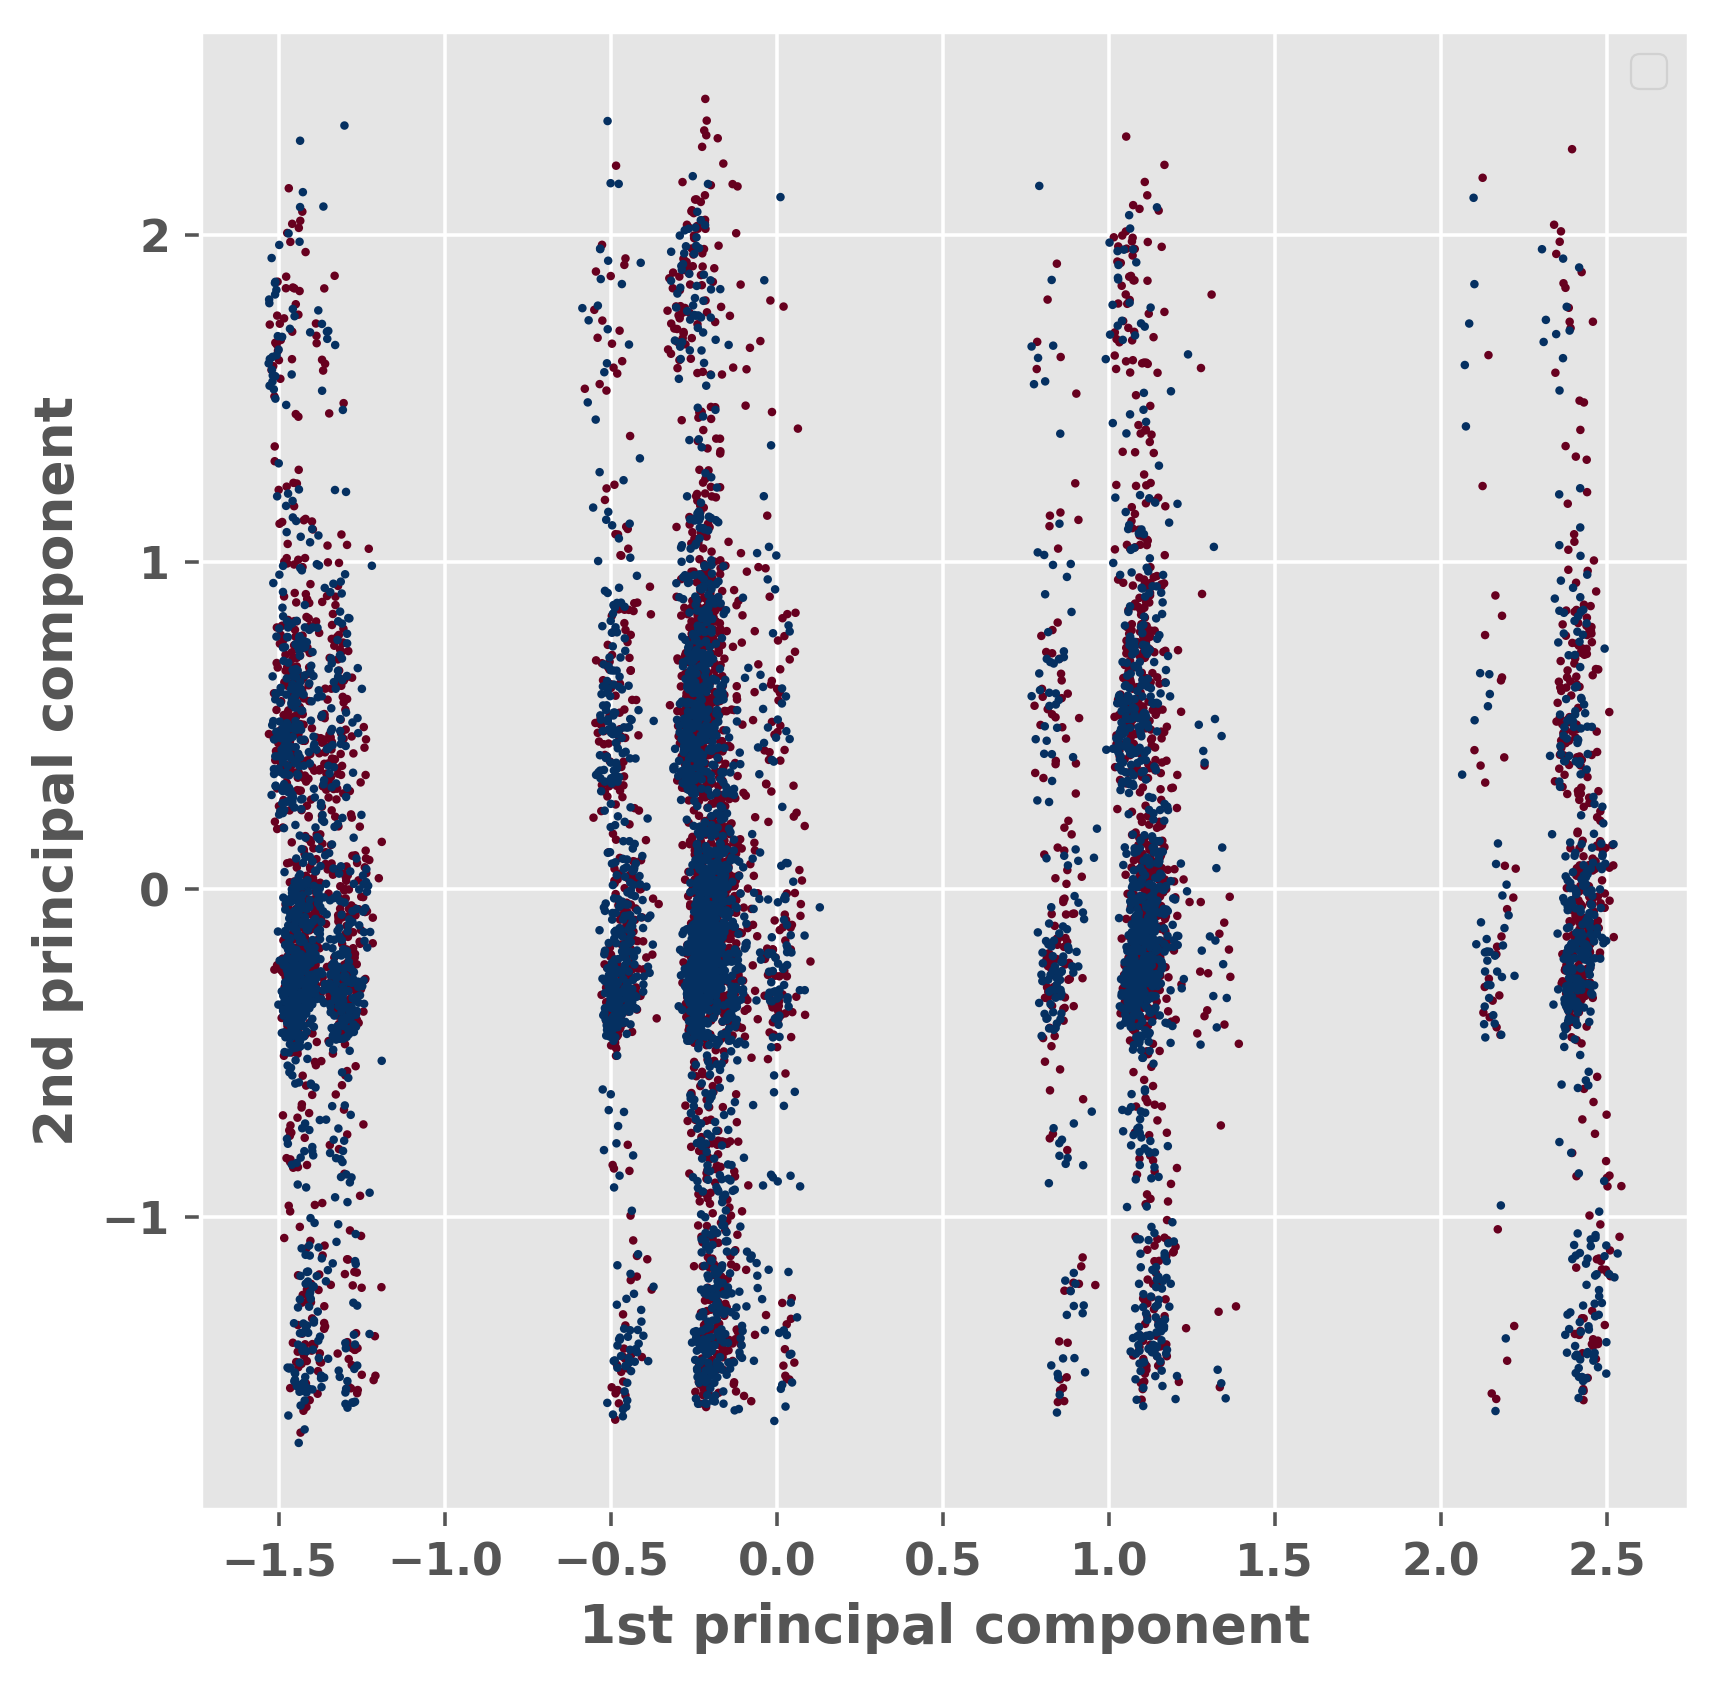

In [116]:
scatter_df = feature_df_pca_clf.iloc[:,:2]
plt.style.use('ggplot')
plt.rcParams["font.weight"] = "bold"
my_colormap = cm.get_cmap(name = 'RdBu')
color_value = np.linspace(start = 0.0, stop = 1, num = 2)
fig, ax = plt.subplots(1, 1, figsize = (6,6), dpi = 320)
ax.scatter(x = scatter_df.iloc[:,0], y = scatter_df.iloc[:,1], c = my_colormap(color_value[np.array(response_res)]), s = 2)
ax.set_xlabel('1st principal component', weight = "bold")
ax.set_ylabel('2nd principal component', weight = "bold")
ax.legend()
plt.show()

##### Feature importance

Random Forest

In [87]:
# get feature importance df
# Gini impurity
# index: feature name col: method
feature_importance_df = pd.DataFrame(
    data = None, 
    dtype = float, 
    index = feature_res.columns, 
    columns = ["rf"]
)
rf_importance = RandomForestClassifier(
    class_weight = "balanced"
)
rf_importance.fit(feature_res, response_res)
importance_array = rf_importance.feature_importances_
for i, name in enumerate(feature_res.columns):
    feature_importance_df.loc[name,"rf"] = importance_array[i]
feature_importance_df.sort_values(
    by = "rf", 
    axis = 0, 
    ascending = False, 
    inplace = True
)
feature_importance_df

,rf
EXT_SOURCE_2,0.074159
DAYS_EMPLOYED,0.047679
DAYS_BIRTH,0.046809
DAYS_REGISTRATION,0.044328
DAYS_ID_PUBLISH,0.043532
...,...
NAME_INCOME_TYPE_Maternity leave,0.000000
ORGANIZATION_TYPE_Trade: type 4,0.000000
FLAG_EMP_PHONE,0.000000
FLAG_MOBIL,0.000000


In [91]:
rfe_rank = rfe_clf.ranking_
rfe_rank_df = pd.DataFrame(
    data = None, 
    dtype = float, 
    index = feature_res.columns, 
    columns = ["rf"]
)
for i, name in enumerate(feature_res.columns):
    rfe_rank_df.loc[name,"rf"] = rfe_rank[i]
rfe_rank_df = rfe_rank_df.loc[feature_importance_df.index, :]
print(f'number of levels: {rfe_rank_df["rf"].unique().shape[0]}')


number of levels: 60


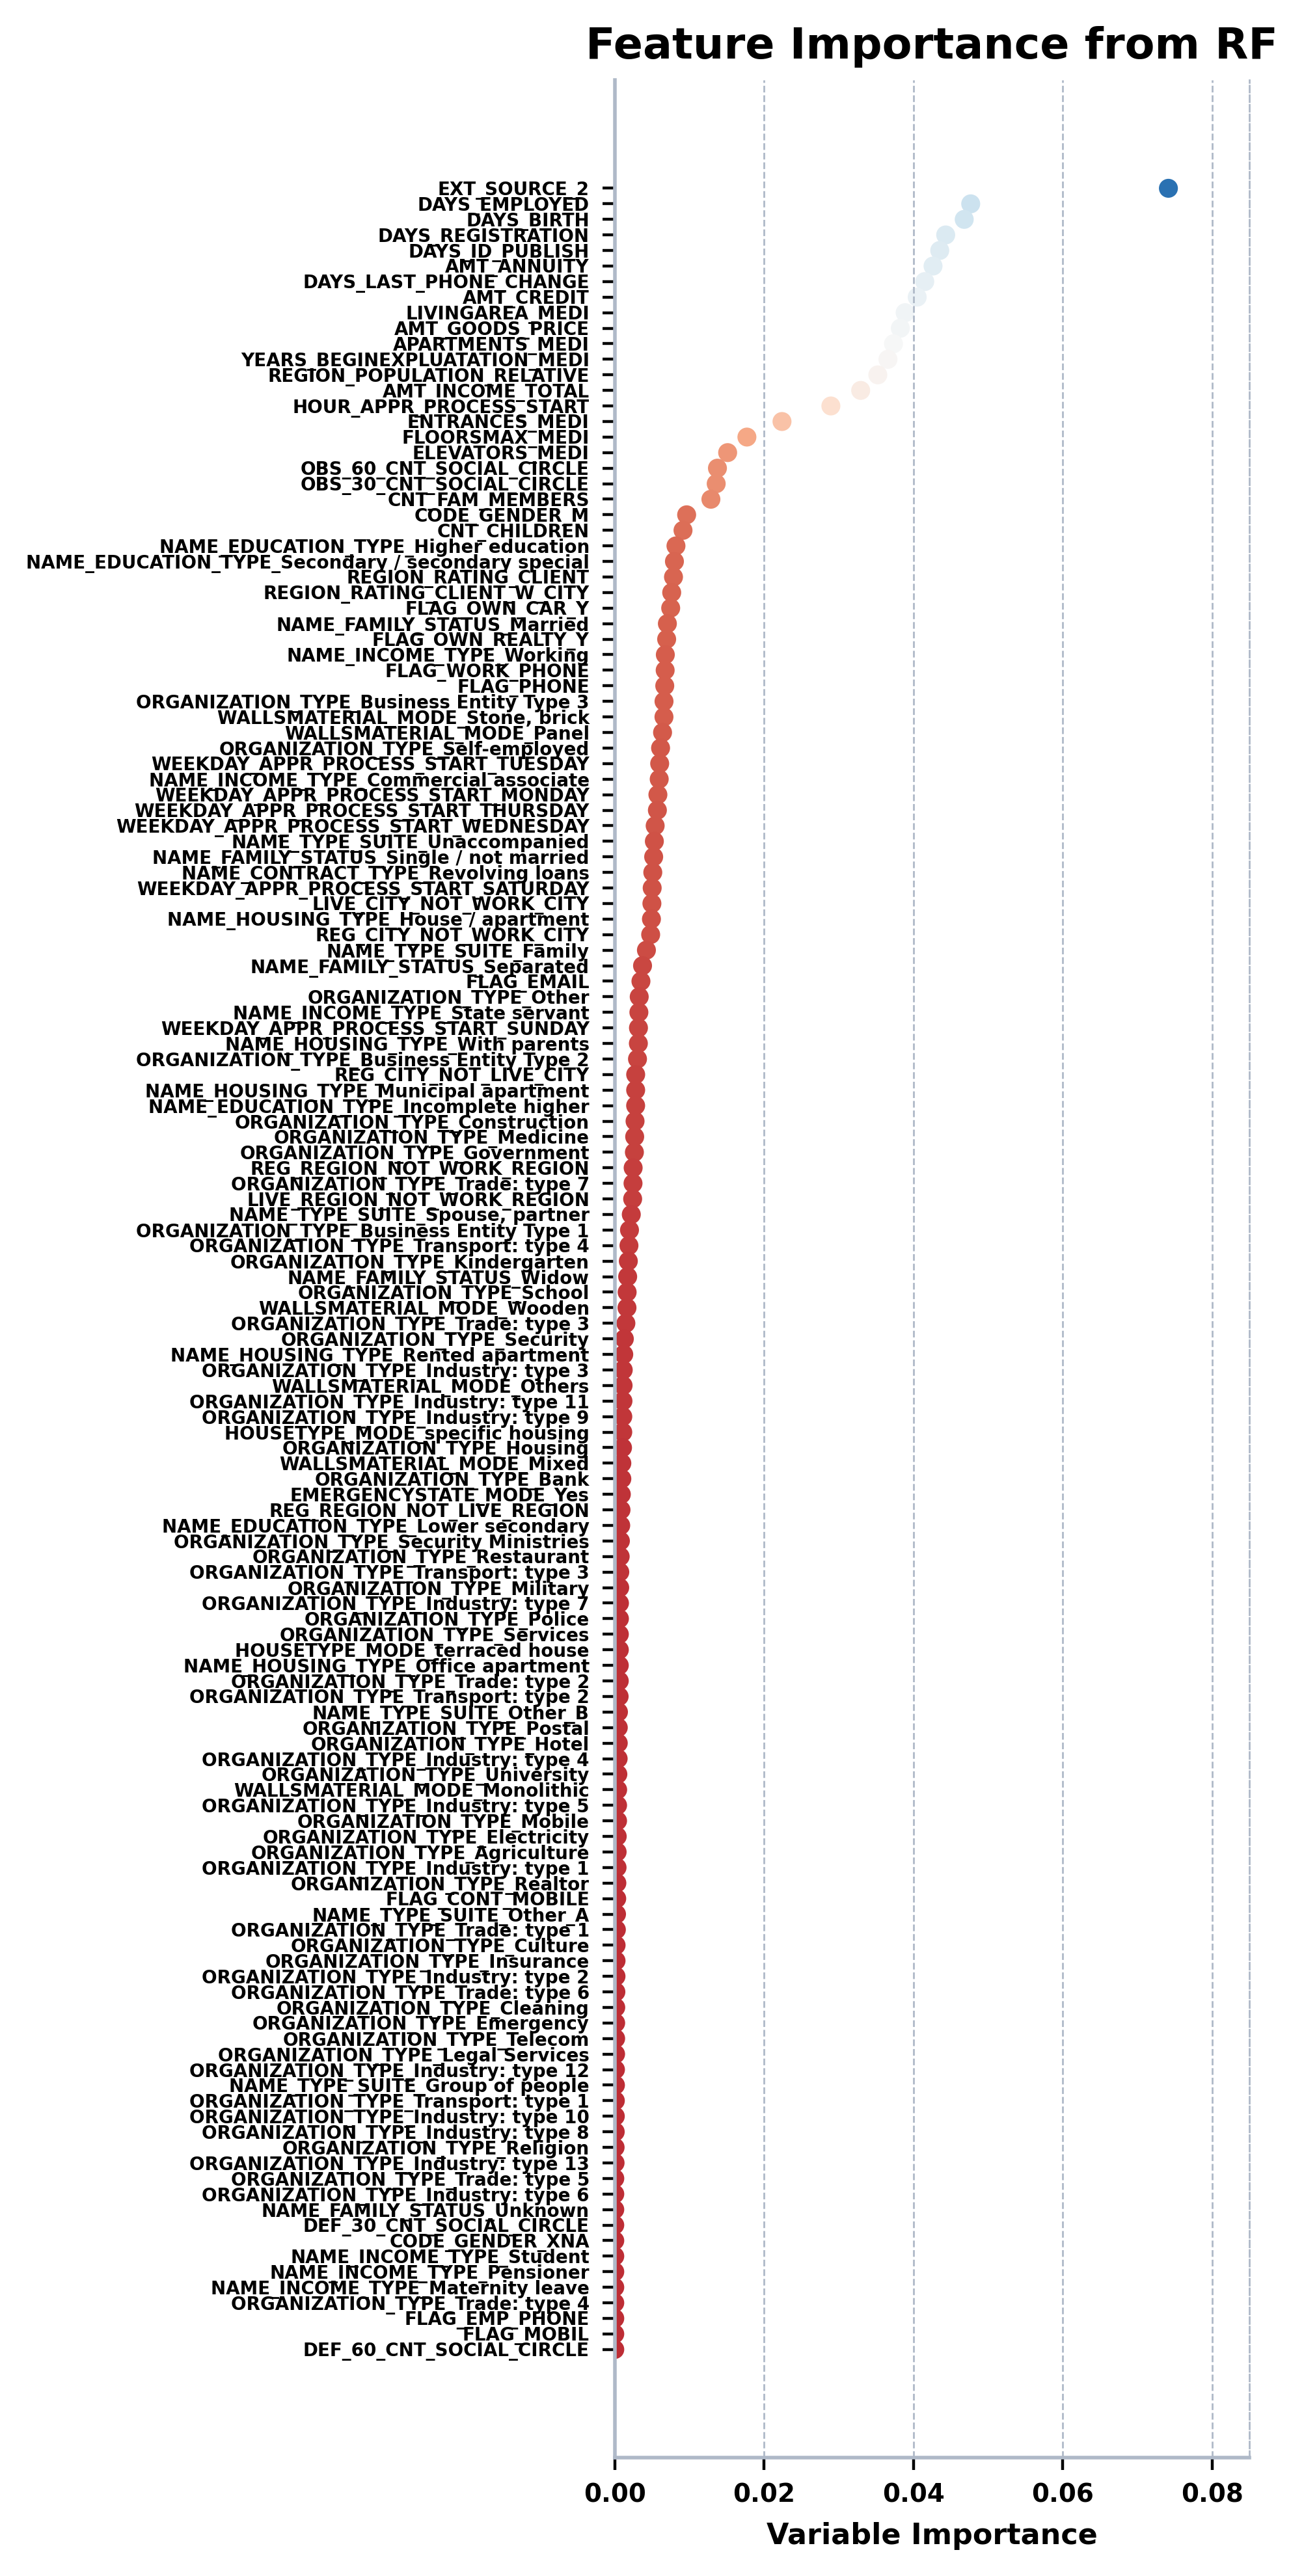

In [112]:
# horizontal scatter plot
outputdir = '/Users/kangshuoli/Documents/VScode_workspace/GR5293/EODS-Project1-Group9/figs/'
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# plt.rcParams['font.sans-serif']=['SimHei']

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams["font.weight"] = "bold"

plt.style.use("default")

fig = plt.figure(figsize = (5,10), dpi = 400, facecolor = "white")
y_pos = np.arange(feature_importance_df.shape[0])
va_name_list = list(feature_importance_df.index)
va_value_list_1 = list(feature_importance_df["rf"])

ax = plt.axes(autoscalex_on = True)

ax.set_yticks(y_pos)
ax.set_yticklabels(va_name_list, fontsize = 5, weight = "bold")
ax.invert_yaxis()
ax.grid(False)

plt.scatter(va_value_list_1, y_pos, color = my_colormap(feature_importance_df["rf"] * 10 + 0.13), s = 18, label = "Random Forest", cmap = my_colormap)

ax.spines['bottom'].set_linewidth(1)
ax.spines['bottom'].set_color([175/255,185/255,200/255])
ax.spines['left'].set_linewidth(1)
ax.spines['left'].set_color([175/255,185/255,200/255])
ax.spines['right'].set_linewidth(0.5)
ax.spines['right'].set_color([175/255,185/255,200/255])
ax.spines['right'].set_linestyle('--')
# ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_visible(False)

fig.patch.set_facecolor('white') 
ax.set_facecolor('white')

# ax.barh(y_pos, va_value_list)
ax.set_xlabel("Variable Importance", fontsize = 8, weight = "bold")
# ax.set_title('Figure 1', fontsize = 10)
# plt.margins(0,0.2)
plt.xticks(np.array([0.00, 0.02, 0.04, 0.06, 0.08]), fontsize = 7, weight = "bold")
plt.xlim([0,0.085])
plt.grid(which = 'major', axis = 'x', color = [175/255,185/255,200/255], linewidth = 0.5, linestyle = '--')
plt.title("Feature Importance from RF", weight = "bold")
plt.tight_layout()
plt.show()
fig.savefig(outputdir + "variable_ranking_gini.png", facecolor = "white", dpi = 400)

RFE

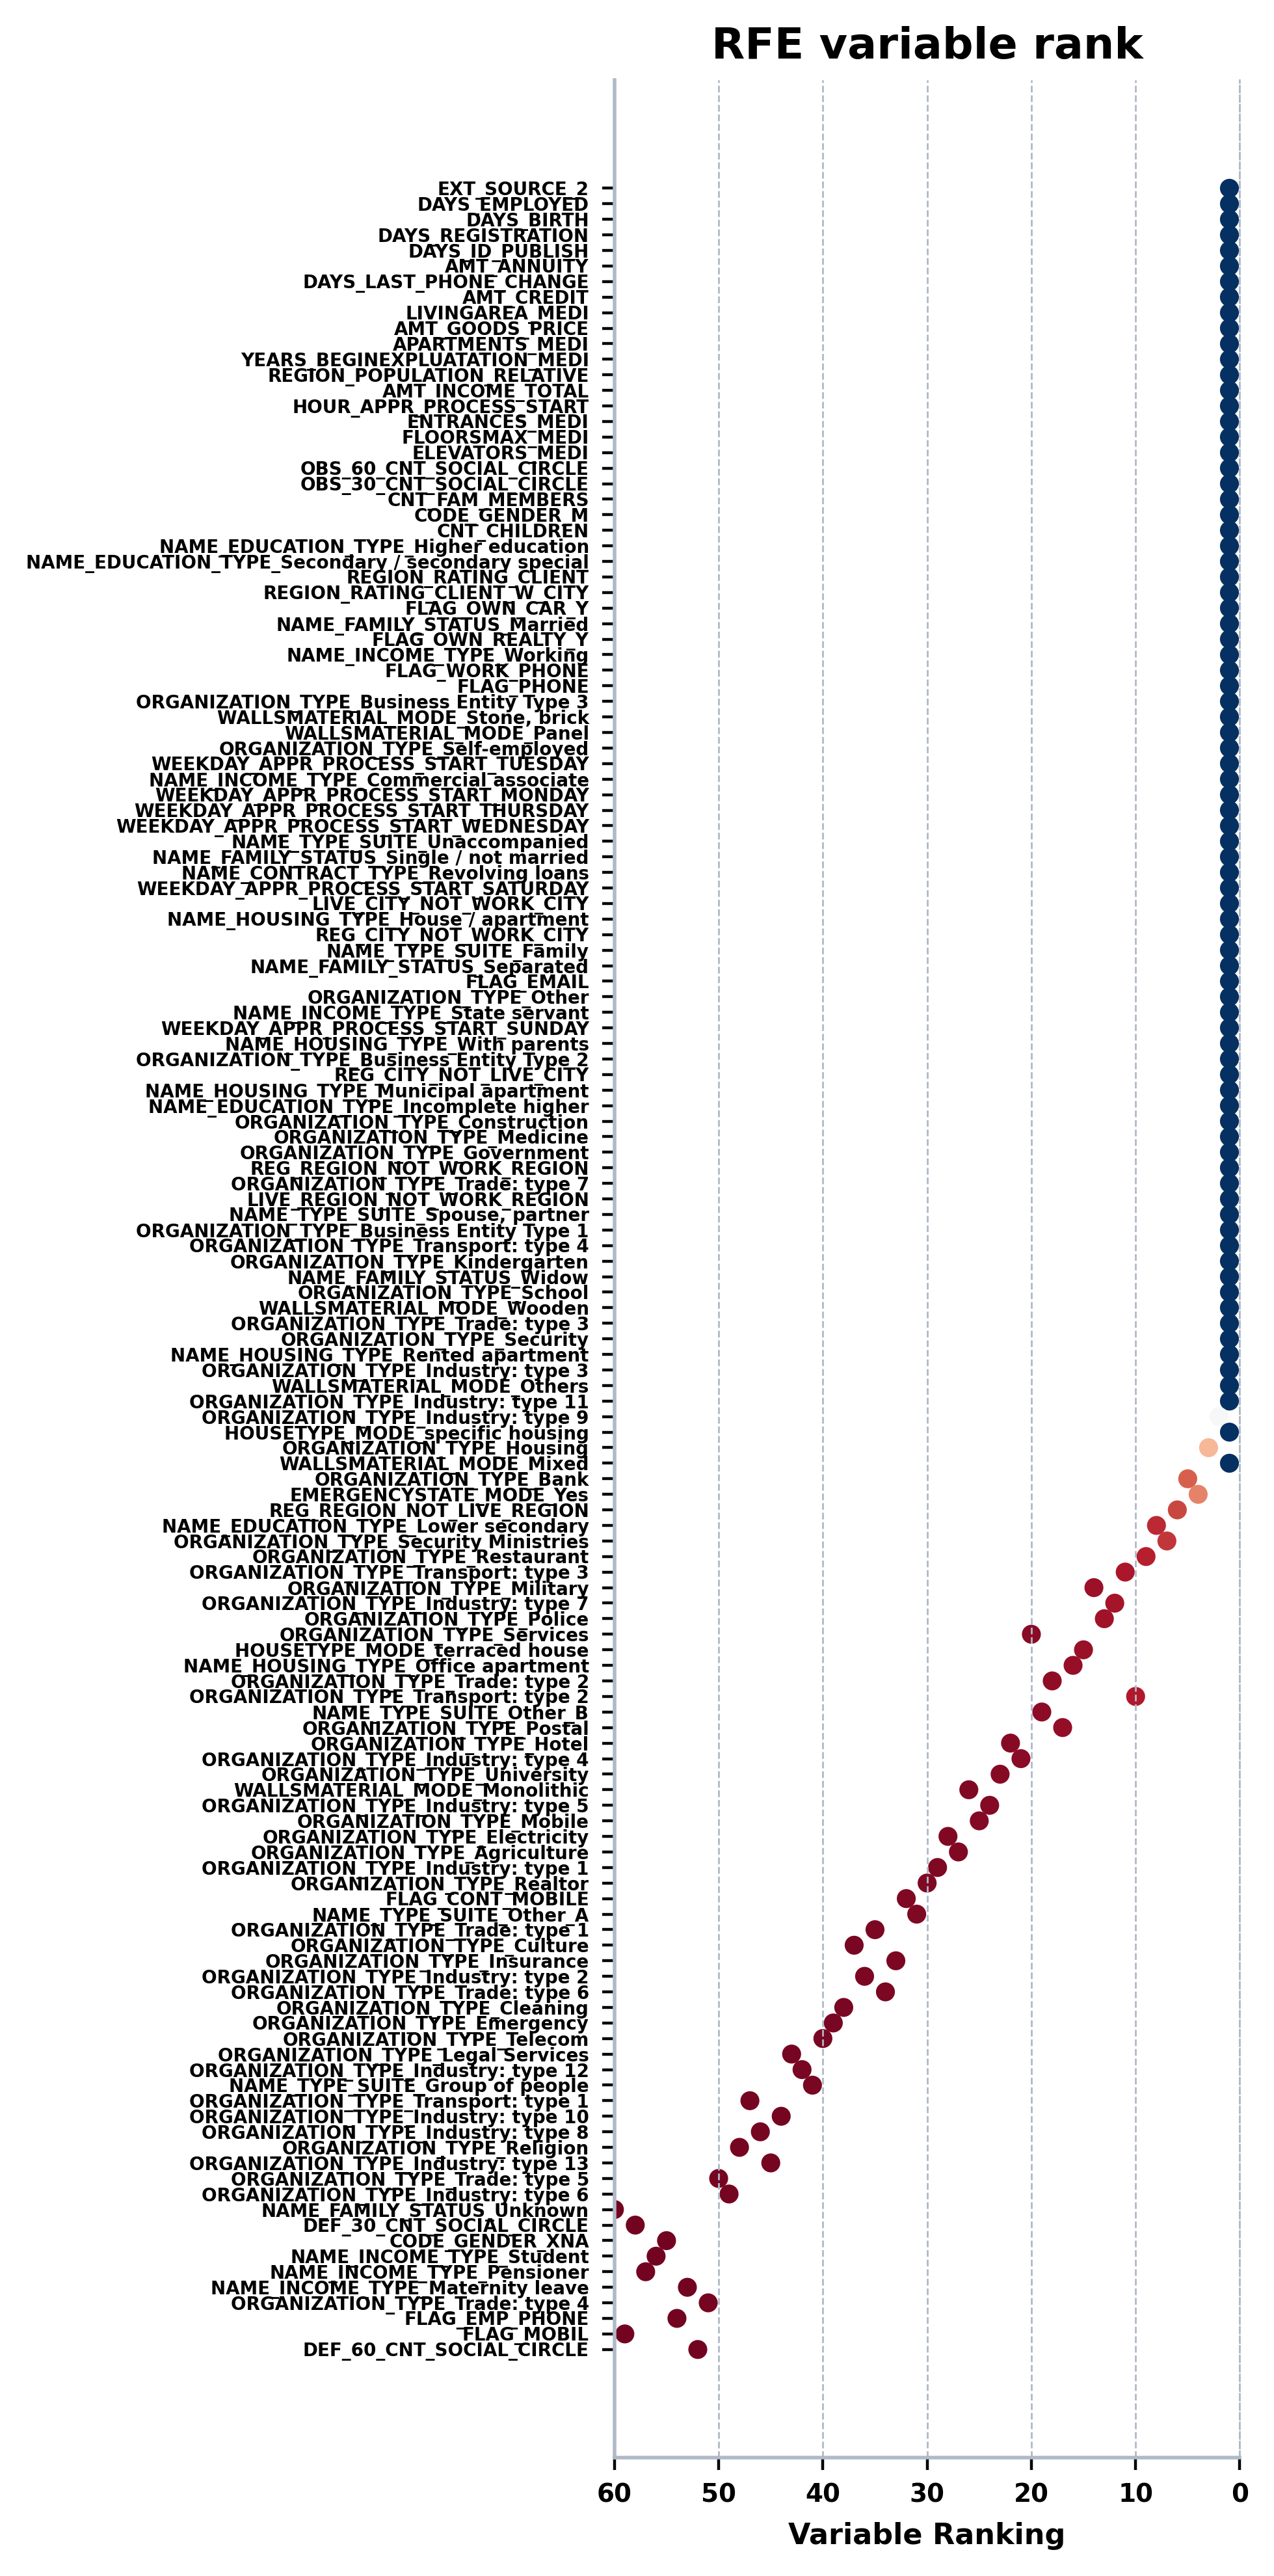

In [115]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams["font.weight"] = "bold"

plt.style.use("default")

fig = plt.figure(figsize = (5,10), dpi = 400, facecolor = "white")
y_pos = np.arange(rfe_rank_df.shape[0])
va_name_list = list(rfe_rank_df.index)
va_value_list_1 = list(rfe_rank_df["rf"])

ax = plt.axes(autoscalex_on = True)

ax.set_yticks(y_pos)
ax.set_yticklabels(va_name_list, fontsize = 5, weight = "bold")
ax.invert_yaxis()
ax.invert_xaxis()
ax.grid(False)

plt.scatter(va_value_list_1, y_pos, s = 18, label = "RFE", color = my_colormap(1 / rfe_rank_df["rf"]))

ax.spines['bottom'].set_linewidth(1)
ax.spines['bottom'].set_color([175/255,185/255,200/255])
ax.spines['left'].set_linewidth(1)
ax.spines['left'].set_color([175/255,185/255,200/255])
ax.spines['right'].set_linewidth(0.5)
ax.spines['right'].set_color([175/255,185/255,200/255])
ax.spines['right'].set_linestyle('--')
# ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_visible(False)

fig.patch.set_facecolor('white') 
ax.set_facecolor('white')

# ax.barh(y_pos, va_value_list)
ax.set_xlabel("Variable Ranking", fontsize = 8, weight = "bold")
# ax.set_title('Figure 1', fontsize = 10)
# plt.margins(0,0.2)
plt.xticks(np.array([0, 10, 20, 30, 40, 50, 60]), fontsize = 7, weight = "bold")
plt.xlim([60, 0])
plt.grid(which = 'major', axis = 'x', color = [175/255,185/255,200/255], linewidth = 0.5, linestyle = '--')
plt.title('RFE variable rank', weight = "bold")
plt.tight_layout()
plt.show()
fig.savefig(outputdir + "variable_ranking_rfe.png", facecolor = "white", dpi = 400)

##### ROC AUC curve

In [ ]:
# roc curve
# all predictors
# predictors selected by select from models
# predictors selected by RFE
# predictors selected by PCA

# tpr fpr
# all predictors
fpr_all_2, tpr_all_2, _ = roc_curve(label_2, booster_all_2.predict_proba(data_filtered_all_2)[:,-1])
fpr_all_5, tpr_all_5, _ = roc_curve(label_5, booster_all_5.predict_proba(data_filtered_all_5)[:,-1])

# predictors selected by select from models
fpr_basic_2, tpr_basic_2, _ = roc_curve(label_2, booster_basic_2.predict_proba(data_filtered_basic_2)[:,-1])
fpr_basic_5, tpr_basic_5, _ = roc_curve(label_5, booster_basic_5.predict_proba(data_filtered_basic_5)[:,-1])

# predictors selected by RFE
fpr_disease_2, tpr_disease_2, _ = roc_curve(label_2, booster_disease_2.predict_proba(data_filtered_disease_2)[:,-1])
fpr_disease_5, tpr_disease_5, _ = roc_curve(label_5, booster_disease_5.predict_proba(data_filtered_disease_5)[:,-1])

# predictors selected by PCA
fpr_bio_2, tpr_bio_2, _ = roc_curve(label_2, booster_bio_2.predict_proba(data_filtered_bio_2)[:,-1])
fpr_bio_5, tpr_bio_5, _ = roc_curve(label_5, booster_bio_5.predict_proba(data_filtered_bio_5)[:,-1])


plt.figure(figsize = (8,8))
# 2-year mortality
ax1 = plt.subplot(1,2,1)
plt.plot([0,1], [0,1], 'k--', linewidth = '2')
plt.plot(fpr_all_2, tpr_all_2, label = 'all predictors', linewidth = '2')
plt.plot(fpr_basic_2, tpr_basic_2, label = 'basic demographics and lifestyle', linewidth = '2')
plt.plot(fpr_disease_2, tpr_disease_2, label = 'disease history and health indicators', linewidth = '2')
plt.plot(fpr_bio_2, tpr_bio_2, label = 'biomarkers', linewidth = '2')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('2-year Mortality')
plt.legend(loc='best')

plt.show()

##### Confusion Matrix

#### Learning curve

#### Feature Selection Curve